<a href="https://colab.research.google.com/github/UVA-DS-6050/DS6050---FA24/blob/main/live_sessions/module-3_4/Regularization_and_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Python ≥3.5 is required
import sys

# Scikit-Learn ≥0.20 is required
import sklearn
print(f"Scikit Learn version: {sklearn.__version__}")

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
print(f"Tensorflow version: {tf.__version__}")
import keras
print(f"Keras version: {keras.__version__}")

# Common imports
import numpy as np
import os

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings("ignore")

Scikit Learn version: 1.3.0


C:\Users\zlism\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Tensorflow version: 2.17.0
Keras version: 3.5.0


Load Dataset and split dataset into train, test and validation

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

Normalize Dataset

In [5]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

Build and Train an unregularized 3-layer fully-connected network on the fashion mnist dataset

Weight Initializers: https://keras.io/api/layers/initializers/ 

In [6]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), # Flattens 2D input into a vector
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal"), # He initializers - https://keras.io/api/layers/initializers/#henormal-class
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

# Set the number of epochs
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8124 - loss: 0.5497 - val_accuracy: 0.8662 - val_loss: 0.3825
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8797 - loss: 0.3290 - val_accuracy: 0.8788 - val_loss: 0.3430


### Regularized Network
https://keras.io/api/layers/regularizers/#layer-weight-regularizers

ADD L2 Regularization Layer and Train for 2 epochs

In [11]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

# Set the number of epochs
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7977 - loss: 3.3159 - val_accuracy: 0.8326 - val_loss: 0.7189
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8247 - loss: 0.7267 - val_accuracy: 0.8430 - val_loss: 0.6897


#### Dropout
https://keras.io/api/layers/regularization_layers/

Build a model with the same architecture and add a dropout regularizer. 
Train for 2 epochs on the same dataset

In [12]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2), # Drop out regularizer turns off nodes randomly with the set probabilty
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2), # Drop out regularizer turns off nodes randomly with the set probabilty
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2), # Drop out regularizer turns off nodes randomly with the set probabilty
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

# Set the number of epochs
n_epochs = 2;
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.7613 - loss: 0.7444 - val_accuracy: 0.8590 - val_loss: 0.3780
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8423 - loss: 0.4281 - val_accuracy: 0.8698 - val_loss: 0.3493


### Optimization for Deep Models

Vanishing/Exploding Gradients Problem

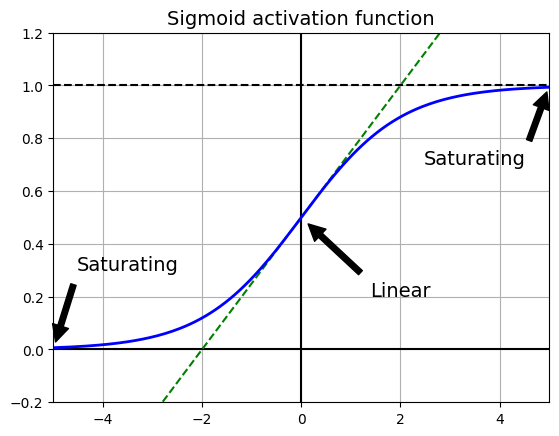

In [13]:
import matplotlib.pyplot as plt

def logit(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

# save_fig("sigmoid_saturation_plot")
plt.show()

Nonsaturating Activation Functions
- Leaky ReLU

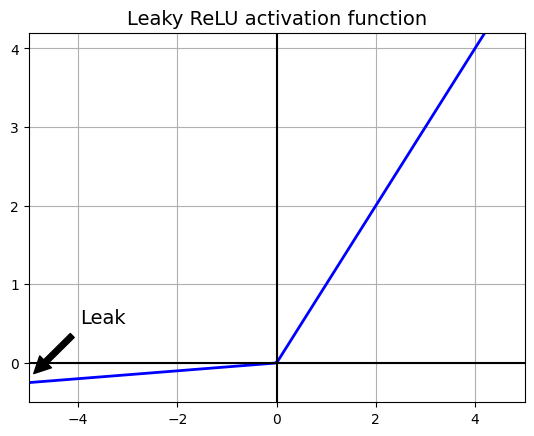

In [14]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

# save_fig("leaky_relu_plot")
plt.show()

#### Activation Functions
Activation functions add non-linearity to each layer of our Deep Neural Network.
https://keras.io/api/layers/activations/

In [15]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'hard_silu',
 'hard_swish',
 'leaky_relu',
 'linear',
 'log_softmax',
 'mish',
 'relu',
 'relu6',
 'selu',
 'serialize',
 'sigmoid',
 'silu',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [17]:
# Train a model using the LeakyReLU activation function
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5064 - loss: 1.6360 - val_accuracy: 0.7390 - val_loss: 0.8578
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7393 - loss: 0.8180 - val_accuracy: 0.7814 - val_loss: 0.6948
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 984us/step - accuracy: 0.7746 - loss: 0.6867 - val_accuracy: 0.8026 - val_loss: 0.6230
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7928 - loss: 0.6220 - val_accuracy: 0.8138 - val_loss: 0.5795
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8044 - loss: 0.5816 - val_accuracy: 0.8196 - val_loss: 0.5500
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 940us/step - accuracy: 0.8127 - loss: 0.5535 - val_accuracy: 0.8242 - val_loss: 0.5284
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 999us/step - accuracy: 0.8191 - loss: 0.5326 - val_accuracy: 0.8300 - val_loss: 0.5118
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8250 - loss: 0.5

In [19]:
# Try with PReLU
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])


history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4794 - loss: 1.7401 - val_accuracy: 0.7242 - val_loss: 0.9147
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7322 - loss: 0.8645 - val_accuracy: 0.7718 - val_loss: 0.7175
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 996us/step - accuracy: 0.7744 - loss: 0.7099 - val_accuracy: 0.7960 - val_loss: 0.6354
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 935us/step - accuracy: 0.7946 - loss: 0.6371 - val_accuracy: 0.8140 - val_loss: 0.5865
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 959us/step - accuracy: 0.8063 - loss: 0.5917 - val_accuracy: 0.8214 - val_loss: 0.5536
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 996us/step - accuracy: 0.8138 - loss: 0.5604 - val_accuracy: 0.8286 - val_loss: 0.5295
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 994us/step - accuracy: 0.8202 - loss: 0.5371 - val_accuracy: 0.8328 - val_loss: 0.5110
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 995us/step - accuracy: 0.8252 - los

#### Layer Weight Initializers
https://keras.io/api/layers/initializers/

In [20]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'IdentityInitializer',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'OrthogonalInitializer',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

#### Model Optimizers
https://keras.io/api/optimizers/

In [21]:
[name for name in dir(keras.optimizers) if not name.startswith("_")]

['Adadelta',
 'Adafactor',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'Ftrl',
 'Lion',
 'LossScaleOptimizer',
 'Nadam',
 'Optimizer',
 'RMSprop',
 'SGD',
 'deserialize',
 'get',
 'legacy',
 'schedules',
 'serialize']

#### Adaptive Learning Rates

In [23]:
# Training with a constant Learning Rate
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7872 - loss: 0.6118 - val_accuracy: 0.8624 - val_loss: 0.4025
Epoch 2/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8624 - loss: 0.3884 - val_accuracy: 0.8704 - val_loss: 0.3706
Epoch 3/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 999us/step - accuracy: 0.8746 - loss: 0.3504 - val_accuracy: 0.8764 - val_loss: 0.3557
Epoch 4/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 988us/step - accuracy: 0.8842 - loss: 0.3258 - val_accuracy: 0.8802 - val_loss: 0.3459
Epoch 5/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8905 - loss: 0.3070 - val_accuracy: 0.8830 - val_loss: 0.3393
Epoch 6/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8954 - loss: 0.2912 - val_accuracy: 0.8822 - val_loss: 0.3348
Epoch 7/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9010 - loss: 0.2778 - val_accuracy: 0.8838 - val_loss: 0.3320
Epoch 8/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9053 - loss: 0.265

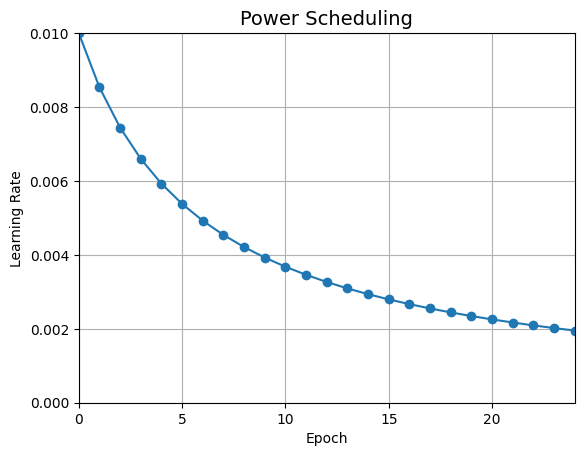

In [24]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [25]:
#### Implementing an exponential scheduled lr
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7532 - loss: 0.9753 - val_accuracy: 0.7814 - val_loss: 0.7245 - learning_rate: 0.0100
Epoch 2/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8028 - loss: 0.6439 - val_accuracy: 0.8070 - val_loss: 0.9183 - learning_rate: 0.0089
Epoch 3/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8236 - loss: 0.6035 - val_accuracy: 0.7344 - val_loss: 0.8671 - learning_rate: 0.0079
Epoch 4/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8212 - loss: 0.5803 - val_accuracy: 0.8292 - val_loss: 0.6630 - learning_rate: 0.0071
Epoch 5/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8423 - loss: 0.5156 - val_accuracy: 0.8502 - val_loss: 0.5723 - learning_rate: 0.0063
Epoch 6/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8552 - loss: 0.4608 - val_accuracy: 0.8592 - val_loss: 0.5151 - learning_rate: 0.0056
Epoch 7/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8626 - l

Performance Scheduling

In [1]:
tf.random.set_seed(42)
np.random.seed(42)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

NameError: name 'tf' is not defined

### Multi-Task Learning: Leveraging Pre-trained Layers

Let's split the fashion MNIST training set in two:

X_train_A: all images of all items except for sandals and shirts (classes 5 and 6).
X_train_B: a much smaller training set of just the first 200 images of sandals or shirts.
The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using Dense layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [2]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

NameError: name 'X_train' is not defined

In [51]:
print(X_train_A.shape)
print(X_train_B.shape)
print(y_train_A[:30])
print(np.unique(y_train_A))
print(y_train_B[:30])
print(np.unique(y_train_B))

(43986, 28, 28)
(200, 28, 28)
[4 0 5 7 7 7 4 4 3 4 0 1 6 3 4 3 2 6 5 3 4 5 1 3 4 2 0 6 7 1]
[0 1 2 3 4 5 6 7]
[1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.
 1. 0. 1. 1. 1. 1.]
[0. 1.]


In [52]:
tf.random.set_seed(42)
np.random.seed(42)

# Build and Train Model A
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

c:\Users\adewo\anaconda3\envs\dl_venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
1375/1375 [==============================] - 18s 12ms/step - loss: 0.5675 - accuracy: 0.8113 - val_loss: 0.3930 - val_accuracy: 0.8622
Epoch 2/20
1375/1375 [==============================] - 15s 11ms/step - loss: 0.3584 - accuracy: 0.8758 - val_loss: 0.3340 - val_accuracy: 0.8799
Epoch 3/20
1375/1375 [==============================] - 19s 14ms/step - loss: 0.3199 - accuracy: 0.8878 - val_loss: 0.3009 - val_accuracy: 0.8961
Epoch 4/20
1375/1375 [==============================] - 15s 11ms/step - loss: 0.2997 - accuracy: 0.8951 - val_loss: 0.2889 - val_accuracy: 0.8979
Epoch 5/20
1375/1375 [==============================] - 14s 10ms/step - loss: 0.2861 - accuracy: 0.9006 - val_loss: 0.2771 - val_accuracy: 0.9063
Epoch 6/20
1375/1375 [==============================] - 14s 11ms/step - loss: 0.2763 - accuracy: 0.9042 - val_loss: 0.2737 - val_accuracy: 0.9048
Epoch 7/20
1375/1375 [==============================] - 16s 12ms/step - loss: 0.2681 - accuracy: 0.9071 - val_loss: 0.2672 -

In [ ]:
# Save Model A
model_A.save("my_model_A.h5")

# Train Model B without pretrained weights from Model A
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid")) # Sigmoid is used for binary classification

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

model.summary()

In [ ]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))


model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

In [ ]:
# Compare Performance of the two models
print(model_B.evaluate(X_test_B, y_test_B))

print(model_B_on_A.evaluate(X_test_B, y_test_B))